In [1]:
from PIL import Image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras_preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#from utils import load_paired_img_wrd
from vector_search import vector_search
import streamlit as st
import numpy as np
import inspect
from argparse import ArgumentParser

import os
import numpy as np
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# Intialize matplotlib parameters

#pd.options.display.max_colwidth = 600


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [3]:
def displayImages(results):
    fig, ax = plt.subplots(1,len(results), figsize=(50,50))
    img_Counter=0;
    for result in results:
        img_path = result[1]
        #print(img_path)
        ax[img_Counter].set_title("")
        ax[img_Counter].imshow(load_img(img_path, target_size=(224, 224)))
        img_Counter = img_Counter + 1

In [4]:
def displayImagebyPath(img_path):
    fig, ax = plt.subplots(1,1, figsize=(50,50))
    img_Counter=0;
    ax[img_Counter].set_title(img_path)
    ax[img_Counter].imshow(load_img(img_path, target_size=(224, 224)))


In [5]:

def load_paired_img_wrd(folder, word_vectors, use_word_vectors=True):
    '''
    If use_word_vectors = true, and using VGG16 with Imagenet:
    Will have 300 embedding layer at end of network
    Instead of 4096 imagenet class layer at the end of the network
    '''
    class_names = [fold for fold in os.listdir(folder) if ".DS" not in fold]
    image_list = []
    labels_list = []
    paths_list = []
    for cl in class_names:
        splits = cl.split("_")
        if use_word_vectors:
            vectors = np.array([word_vectors[split] if split in word_vectors else np.zeros(shape=300) for split in splits])
            class_vector = np.mean(vectors, axis=0)
        subfiles = [f for f in os.listdir(folder + "/" + cl) if ".DS" not in f]

        for subf in subfiles:
            #print("subf: " + subf)
            full_path = os.path.join(folder, cl, subf)
            #print("full path : " + full_path)
            img = image.load_img(full_path, target_size=(224, 224))
            #print(type(img))
            
            x_raw = image.img_to_array(img)
            #print(x_raw.shape)
            x_expand = np.expand_dims(x_raw, axis=0)
            #print("after expand")
            #print(x_expand.shape)
            x = preprocess_input(x_expand)
            #print("after preprocess")
            #print(x.shape)
            image_list.append(x)
            if use_word_vectors:
                labels_list.append(class_vector)
            paths_list.append(full_path)
    img_data = np.array(image_list)
    #print("image_data_shape")
    #print(img_data.shape)
    #print("image_data_type")
    #print(type(img_data))
    
    
    img_data = np.rollaxis(img_data, 1, 0)
    img_data = img_data[0]

    return img_data, np.array(labels_list), paths_list

In [6]:
def load_images_vectors_paths(glove_model_path, data_path):
    word_vectors = vector_search.load_glove_vectors(glove_model_path)
    images, vectors, image_paths = load_paired_img_wrd(data_path, word_vectors)
    return images, vectors, image_paths, word_vectors


In [48]:
glove_model_path = "/Volumes/My Passport for Mac/model/glove.6B"
data_path = "/Volumes/My Passport for Mac/data/imagesearch/"
features_path = "/Volumes/My Passport for Mac/model/imagesearch/features"
file_mapping_path = "/Volumes/My Passport for Mac/model/imagesearch/filemapping"
custom_features_path = "/Volumes/My Passport for Mac/model/imagesearch/customfeatures"
custom_features_file_mapping_path = "/Volumes/My Passport for Mac/model/imagesearch/customfilemapping"

In [8]:
model = vector_search.load_headless_pretrained_model()


Loading headless pretrained model...


In [9]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [10]:
images, vectors, image_paths, word_vectors = load_images_vectors_paths(glove_model_path, data_path)

Found 400000 word vectors.


[-7.9543e-02  5.4471e-01  2.4225e-01 -3.2750e-01 -2.6700e-01 -3.5527e-04
 -9.1719e-01  1.3726e-01  1.3382e-01  6.4644e-01  8.3347e-01  2.5037e-01
  7.6380e-01 -5.5370e-01  1.3632e-01  9.0997e-02  7.6841e-02 -2.8499e-01
  5.7465e-01 -1.9088e-01  1.1889e-01 -3.4401e-01 -3.6842e-01  2.1014e-01
  5.1092e-01  1.6333e-01  2.9509e-01  3.2380e-01  3.6402e-01  7.4991e-01
  1.3047e-01  5.3260e-02  7.3911e-01 -4.9012e-03  7.3496e-01 -5.8971e-01
 -1.4170e-01 -1.5034e-01 -4.3262e-02 -3.6860e-01 -8.3711e-02  8.4077e-01
  6.3594e-01  3.8586e-01 -3.4692e-01  7.6265e-02  3.5669e-01  7.0530e-02
  6.0107e-02 -9.6640e-01  2.5768e-01 -7.5547e-02  6.7249e-01  4.6957e-01
 -2.1492e-01  3.5964e-01  6.1504e-01 -4.8495e-01  1.2023e-01 -4.2716e-02
  3.9075e-01  2.5456e-01  2.5527e-02  3.9511e-01  1.2797e-01  1.1204e-01
  3.5158e-01 -2.1635e-01  3.6546e-01 -6.1485e-01 -4.6515e-02 -5.7427e-01
 -2.0521e-01 -6.4783e-04  5.9327e-01 -5.7835e-01  2.7079e-01 -4.6304e-01
 -6.0964e-01 -8.3917e-02 -1.3290e-01 -4.2505e-01  2

In [12]:
#data_path = "/Volumes/My Passport for Mac/data/temp/"
images, vectors, image_paths = load_paired_img_wrd(data_path, word_vectors)

In [13]:
generate_image_features = False
model = vector_search.load_headless_pretrained_model()
if generate_image_features:
    images_features, file_index = vector_search.generate_features(image_paths, model)
    vector_search.save_features(features_path, images_features, file_mapping_path, file_index)
else:
    print("loading image features from disk")
    images_features, file_index = vector_search.load_features(features_path, file_mapping_path)


Loading headless pretrained model...
loading image features from disk
Loading features...


In [14]:
image_index = vector_search.index_features(images_features)

Indexing features...


In [15]:
results = vector_search.search_index_by_key(200, image_index, file_index)

In [16]:
print(results)


[[200, '/Volumes/My Passport for Mac/data/imagesearch/bottle/2008_000112.jpg', 0.0001562217657919973], [375, '/Volumes/My Passport for Mac/data/imagesearch/cat/2008_004635.jpg', 0.9413783550262451], [399, '/Volumes/My Passport for Mac/data/imagesearch/cat/2008_007888.jpg', 0.9977052211761475], [361, '/Volumes/My Passport for Mac/data/imagesearch/cat/2008_002201.jpg', 1.0260729789733887], [778, '/Volumes/My Passport for Mac/data/imagesearch/potted_plant/2008_006068.jpg', 1.0308609008789062], [370, '/Volumes/My Passport for Mac/data/imagesearch/cat/2008_003622.jpg', 1.0327214002609253], [360, '/Volumes/My Passport for Mac/data/imagesearch/cat/2008_002067.jpg', 1.032860517501831], [220, '/Volumes/My Passport for Mac/data/imagesearch/bottle/2008_004795.jpg', 1.0681318044662476], [381, '/Volumes/My Passport for Mac/data/imagesearch/cat/2008_005386.jpg', 1.0685954093933105], [445, '/Volumes/My Passport for Mac/data/imagesearch/chair/2008_007941.jpg', 1.0740227699279785]]


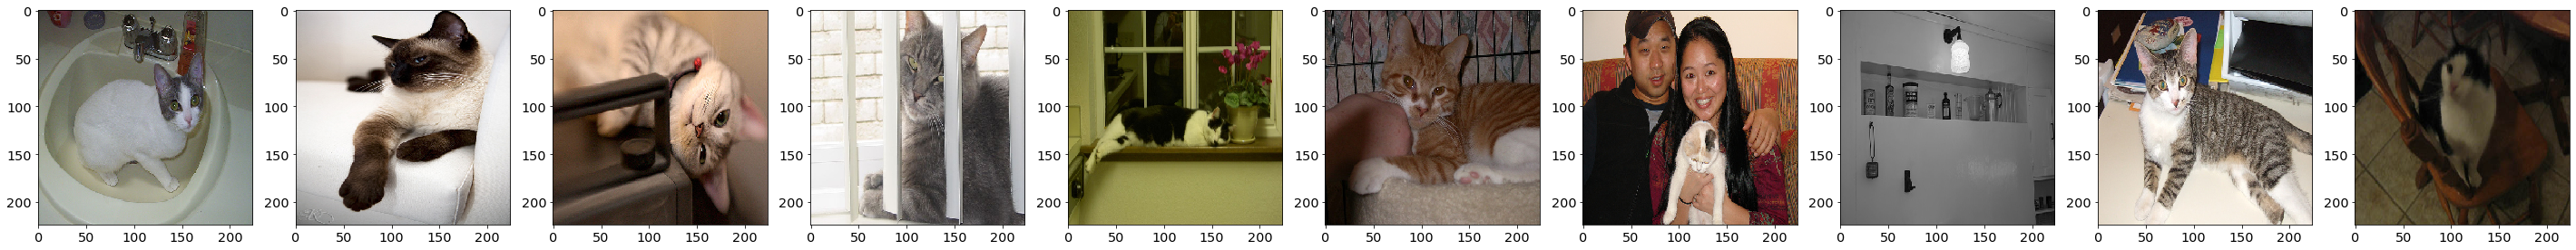

In [17]:
displayImages(results)

In [18]:
# Index 284 is the index for the Siamese cat class in Imagenet
weighted_features = vector_search.get_weighted_features(200, images_features)
weighted_index = vector_search.index_features(weighted_features)
weighted_results = vector_search.search_index_by_key(200, weighted_index, file_index)

Indexing features...


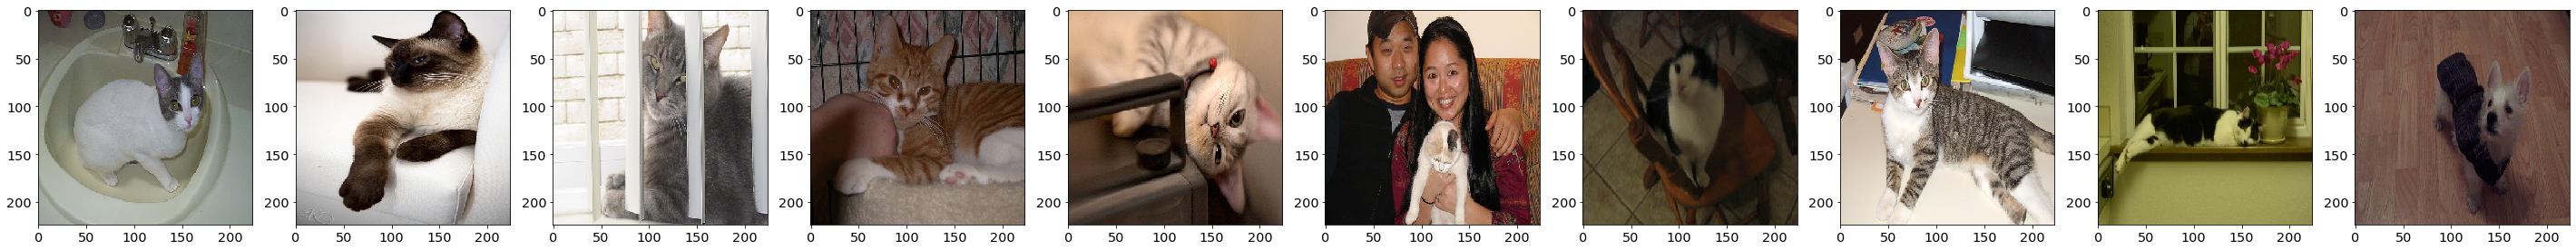

In [19]:
displayImages(weighted_results)

### Image Search by Feature Vector

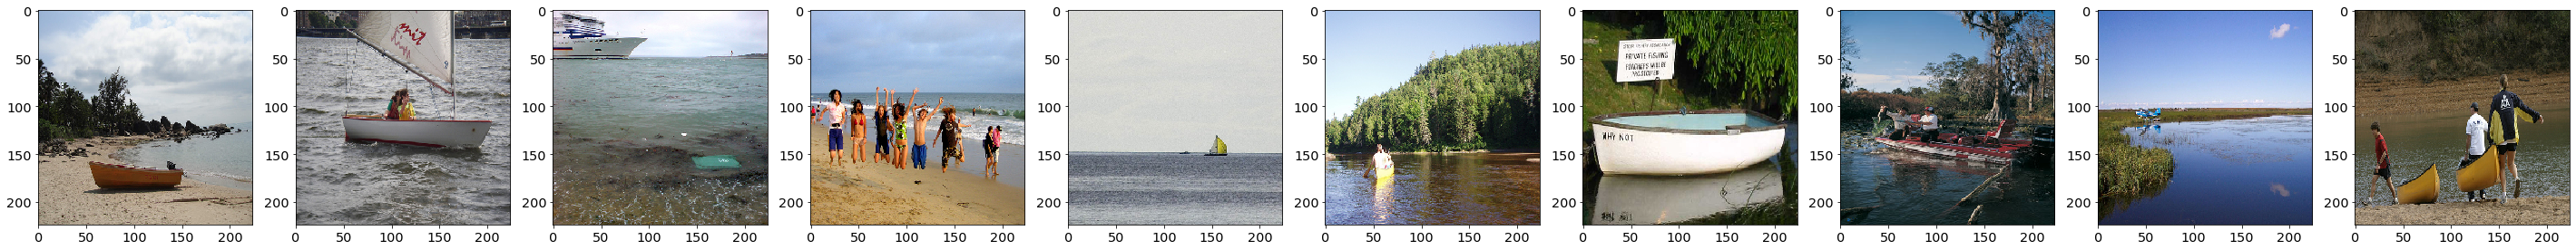

In [34]:
#fv = vector_search.get_feature_vector(model, "/Volumes/My Passport for Mac/data/imagesearch/aeroplane/2008_000716.jpg")
#fv = vector_search.get_feature_vector(model, "/Volumes/My Passport for Mac/data/imagesearch/bird/2008_000095.jpg")
fv = vector_search.get_feature_vector(model, "/Volumes/My Passport for Mac/data/imagesearch/boat/2008_004014.jpg")

results = vector_search.search_index_by_value(fv, image_index, file_index)
displayImages(results)

In [37]:
print(word_vectors["photoshop"])

[-7.9543e-02  5.4471e-01  2.4225e-01 -3.2750e-01 -2.6700e-01 -3.5527e-04
 -9.1719e-01  1.3726e-01  1.3382e-01  6.4644e-01  8.3347e-01  2.5037e-01
  7.6380e-01 -5.5370e-01  1.3632e-01  9.0997e-02  7.6841e-02 -2.8499e-01
  5.7465e-01 -1.9088e-01  1.1889e-01 -3.4401e-01 -3.6842e-01  2.1014e-01
  5.1092e-01  1.6333e-01  2.9509e-01  3.2380e-01  3.6402e-01  7.4991e-01
  1.3047e-01  5.3260e-02  7.3911e-01 -4.9012e-03  7.3496e-01 -5.8971e-01
 -1.4170e-01 -1.5034e-01 -4.3262e-02 -3.6860e-01 -8.3711e-02  8.4077e-01
  6.3594e-01  3.8586e-01 -3.4692e-01  7.6265e-02  3.5669e-01  7.0530e-02
  6.0107e-02 -9.6640e-01  2.5768e-01 -7.5547e-02  6.7249e-01  4.6957e-01
 -2.1492e-01  3.5964e-01  6.1504e-01 -4.8495e-01  1.2023e-01 -4.2716e-02
  3.9075e-01  2.5456e-01  2.5527e-02  3.9511e-01  1.2797e-01  1.1204e-01
  3.5158e-01 -2.1635e-01  3.6546e-01 -6.1485e-01 -4.6515e-02 -5.7427e-01
 -2.0521e-01 -6.4783e-04  5.9327e-01 -5.7835e-01  2.7079e-01 -4.6304e-01
 -6.0964e-01 -8.3917e-02 -1.3290e-01 -4.2505e-01  2

In [38]:
word_index, word_mapping = vector_search.build_word_index(word_vectors)

Creating mapping and list of features
Building tree


Building word index ...
Indexing features...


Tree built


In [41]:
fv = word_vectors["said"]
results = vector_search.search_index_by_value(fv, word_index, word_mapping)

In [42]:
print(results)

[[16, 'said', 0.00035706066410057247], [154, 'told', 0.688713550567627], [345, 'saying', 0.8154540061950684], [476, 'asked', 0.872875452041626], [2360, 'insisted', 0.9087803363800049], [3852, 'noting', 0.9151611328125], [1212, 'warned', 0.915908694267273], [859, 'reporters', 0.9325975179672241], [2549, 'acknowledged', 0.9340296983718872], [171, 'tuesday', 0.9446316957473755]]


In [44]:
custom_model = vector_search.setup_custom_model()

Setting up custom model ...


In [45]:
model_save_path = "/Volumes/My Passport for Mac/model/imagesearch/model2.hdf5"
model_load_oath = "/Volumes/My Passport for Mac/model/imagesearch/model2.hdf5"

train_model = False
if train_model:
    num_epochs = 50
    batch_size = 32
    print("Training for %s epochs, this might take a while, "
            "change train_model to False to load pre-trained model" % num_epochs)
    x, y = shuffle(images, vectors, random_state=2)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
    checkpointer = ModelCheckpoint(filepath='checkpoint.hdf5', verbose=1, save_best_only=True)
    custom_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                         epochs=num_epochs, batch_size=batch_size, callbacks=[checkpointer])
    custom_model.save(model_save_path)
else:
    st.write("Loading model from `%s`" % model_load_path)
    custom_model = load_model(model_load_path)

Training for 50 epochs, this might take a while, change train_model to False to load pre-trained model
Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 74s 93ms/step - loss: -0.0273 - val_loss: -0.0760

Epoch 00001: val_loss improved from inf to -0.07600, saving model to checkpoint.hdf5
Epoch 2/50
800/800 [==============================] - 74s 92ms/step - loss: -0.1286 - val_loss: -0.1821

Epoch 00002: val_loss improved from -0.07600 to -0.18214, saving model to checkpoint.hdf5
Epoch 3/50
800/800 [==============================] - 72s 90ms/step - loss: -0.2149 - val_loss: -0.2576

Epoch 00003: val_loss improved from -0.18214 to -0.25763, saving model to checkpoint.hdf5
Epoch 4/50
800/800 [==============================] - 72s 90ms/step - loss: -0.2762 - val_loss: -0.3117

Epoch 00004: val_loss improved from -0.25763 to -0.31166, saving model to checkpoint.hdf5
Epoch 5/50
800/800 [==============================] - 72s 90ms/step - loss: 

800/800 [==============================] - 72s 90ms/step - loss: -0.6972 - val_loss: -0.6562

Epoch 00042: val_loss improved from -0.65319 to -0.65623, saving model to checkpoint.hdf5
Epoch 43/50
800/800 [==============================] - 72s 91ms/step - loss: -0.6971 - val_loss: -0.6588

Epoch 00043: val_loss improved from -0.65623 to -0.65879, saving model to checkpoint.hdf5
Epoch 44/50
800/800 [==============================] - 73s 91ms/step - loss: -0.7016 - val_loss: -0.6612

Epoch 00044: val_loss improved from -0.65879 to -0.66118, saving model to checkpoint.hdf5
Epoch 45/50
800/800 [==============================] - 72s 90ms/step - loss: -0.7015 - val_loss: -0.6635

Epoch 00045: val_loss improved from -0.66118 to -0.66349, saving model to checkpoint.hdf5
Epoch 46/50
800/800 [==============================] - 72s 90ms/step - loss: -0.7126 - val_loss: -0.6659

Epoch 00046: val_loss improved from -0.66349 to -0.66588, saving model to checkpoint.hdf5
Epoch 47/50
800/800 [===========

NameError: name 'hybrid_images_features' is not defined

In [49]:
generate_custom_features = True
if generate_custom_features:
    hybrid_images_features, file_mapping = vector_search.generate_features(image_paths, custom_model)
    vector_search.save_features(custom_features_path, hybrid_images_features, custom_features_file_mapping_path,
                                file_mapping)
else:
    hybrid_images_features, file_mapping = vector_search.load_features(custom_features_path,
                                                                       custom_features_file_mapping_path)
image_index = vector_search.index_features(hybrid_images_features, dims=300)

Generating features...


1000 images loaded
Images preprocessed
Inference done, 81.50909900665283 Generation time


Saving features...


Weights saved


Indexing features...


In [56]:
print(file_mapping[200])
results = vector_search.search_index_by_value(hybrid_images_features[200], word_index, word_mapping)
print(results)

/Volumes/My Passport for Mac/data/imagesearch/bottle/2008_000112.jpg
[[65182, '12-ounce', 1.074228286743164], [16883, 'vodka', 1.1045717000961304], [19045, 'whiskey', 1.1095694303512573], [32009, 'shampoo', 1.123459815979004], [16490, 'drank', 1.1387935876846313], [24478, 'whisky', 1.1402294635772705], [30627, 'puppies', 1.1581995487213135], [54577, 'unopened', 1.1600747108459473], [20613, 'gin', 1.1626496315002441], [69952, '16-ounce', 1.1710278987884521]]


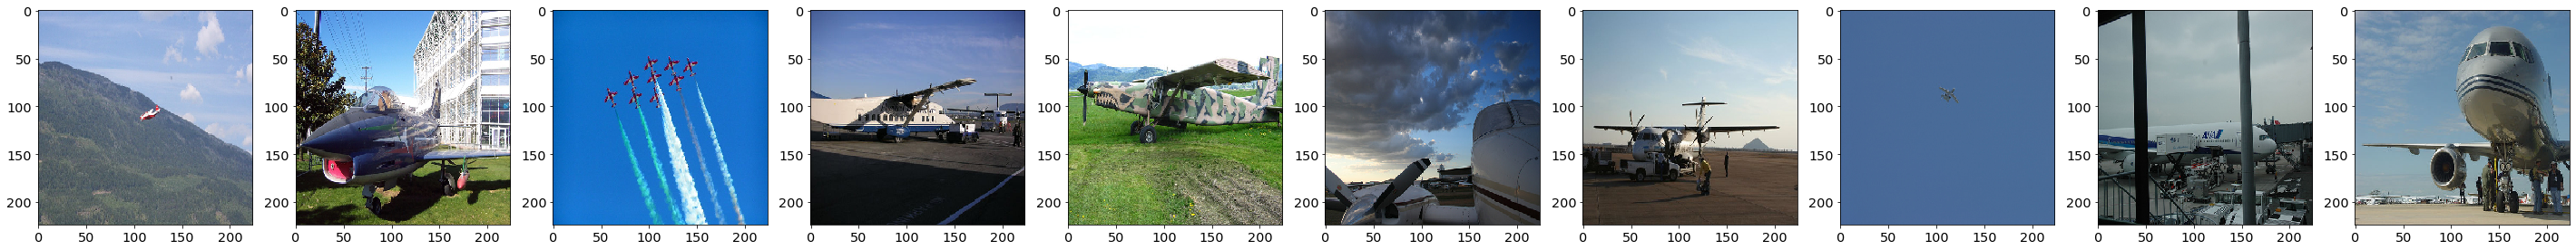

In [59]:
results = vector_search.search_index_by_value(word_vectors["aeroplane"], image_index, file_mapping)
displayImages(results)

### Untrained Words

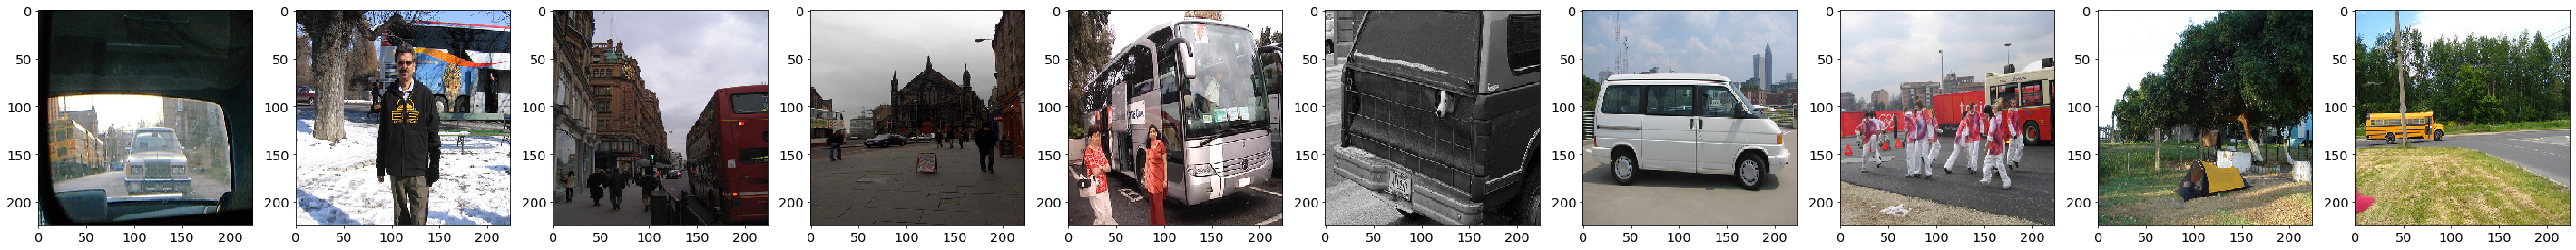

In [62]:
results = vector_search.search_index_by_value(word_vectors["street"], image_index, file_mapping)
displayImages(results)